In [1]:
from __future__ import division
import numpy as np
import tensorflow as tf
from string import uppercase
from captcha.image import ImageCaptcha

In [2]:
width = 100
height = 60
# charset = '0123456789'
charset = '0123456789' + uppercase
captchaLength = 4
imageSize = width * height
alpha = 1e-3

In [3]:
def getCode():
    return ''.join(map(
        lambda x: charset[x], 
        np.random.randint(0, len(charset), captchaLength)
    ))
captcha = ImageCaptcha(width=width, height=height)

In [4]:
def getData(n = 10):    
    codeList = [getCode() for _ in range(n)]
    imageList = map(lambda code: captcha.generate_image(code), codeList)
    return imageList, codeList

In [5]:
def weight_variable(shape):
    initial = tf.random_normal(shape, stddev=0.01)                                                                                                     
    return tf.Variable(initial)   

In [6]:
def bias_variable(shape):
    initial = tf.random_normal(shape, stddev=0.1)
    return tf.Variable(initial)   

In [7]:
def conv2d(x, W): 
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [8]:
def max_pool(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [9]:
def imageToVertor(image):
    """ 将图片转化为向量表示 """
    image = image.convert("L")
    image = np.asarray(image)
    image = image.reshape([width * height]) / 255
    return image

In [10]:
def codeToVertor(code):
    """ 将验证码转化为向量表示 """
    labels = np.zeros([captchaLength, len(charset)])
    for i in range(captchaLength):
        labels[i, charset.index(code[i])] = 1
    return labels.reshape(len(charset) * captchaLength)

JGFW


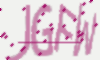

In [11]:
# 测试验证码
code = getCode()
print code
captcha.generate_image(code)

In [12]:
# 定义输入输出
x = tf.placeholder(tf.float32, shape=[None, imageSize])
y = tf.placeholder(tf.float32, shape=[None, len(charset) * captchaLength])
keep_prob = tf.placeholder(tf.float32)
x_image = tf.reshape(x, shape=[-1, width, height, 1])

In [13]:
# 定义第一层卷积
conv_layer1_weight = weight_variable([5, 5, 1, 32])
conv_layer1_bias = bias_variable([32])
pool_layer1 = max_pool(
    tf.nn.relu(conv2d(x_image, conv_layer1_weight) + conv_layer1_bias))

In [14]:
# 定义第二层卷积
conv_layer2_weight = weight_variable([5, 5, 32, 64])
conv_layer2_bias = bias_variable([64])
pool_layer2 = max_pool(
    tf.nn.relu(conv2d(pool_layer1, conv_layer2_weight) + conv_layer2_bias)) 

In [15]:
# 定义第三层卷积
conv_layer3_weight = weight_variable([5, 5, 64, 64])
conv_layer3_bias = bias_variable([64])
pool_layer3 = max_pool(
    tf.nn.relu(conv2d(pool_layer2, conv_layer3_weight) + conv_layer3_bias))

In [16]:
lastWidth = int(round(width / 8))
lastHeight = int(round(height / 8))

In [17]:
# 定义全连接层
fc_layer_weight = weight_variable([lastWidth * lastHeight * 64, 1024])
fc_layer_bias = bias_variable([1024])
pool_layer3_flat = tf.reshape(pool_layer3, [-1, lastWidth * lastHeight * 64])
fc_layer = tf.nn.relu(tf.add(tf.matmul(pool_layer3_flat, fc_layer_weight), fc_layer_bias))

In [18]:
# Dropout层
fc_layer_drop = tf.nn.dropout(fc_layer, keep_prob)

In [19]:
# Readout层
output_layer_weight = weight_variable([1024, len(charset) * captchaLength])
output_layer_bias = bias_variable([len(charset) * captchaLength])
y_conv = tf.add(tf.matmul(fc_layer_drop, output_layer_weight), output_layer_bias)

In [20]:
# 定义输出函数
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_conv))
optimizer = tf.train.AdamOptimizer(alpha).minimize(loss)
prediction = tf.argmax(tf.reshape(y_conv, [-1, captchaLength, len(charset)]), 2)
correct = tf.argmax(tf.reshape(y, [-1, captchaLength, len(charset)]), 2)                                                           
correct_prediction = tf.equal(prediction, correct)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
# 初始化session
saver = tf.train.Saver()
session = tf.Session()
session.run(tf.global_variables_initializer())

In [ ]:
for step in range(1, 1000):
    imageList, codeList = getData(100)
    x_data = map(imageToVertor, imageList)
    y_data = map(codeToVertor, codeList)
    _, l = session.run([optimizer, loss], feed_dict={x: x_data, y: y_data, keep_prob: .75})
    saver.save(session, 'model/model', global_step=step)
    print '[%d]: loss: %f' % (step, l)

[1]: loss: 0.689582
[2]: loss: 0.622208
[3]: loss: 0.439838
[4]: loss: 0.185140
[5]: loss: 0.164710
[6]: loss: 0.252127
[7]: loss: 0.266934
[8]: loss: 0.229840
[9]: loss: 0.178243
